In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [6]:
url = 'https://github.com/mufeezmomin30/datasciencecoursera/blob/master/KPMG_VI_New_raw_data_update_final.xlsx?raw=true'
xls = pd.ExcelFile(url)
title = pd.read_excel(xls, 'Title Sheet')
old_trans = pd.read_excel(xls, 'Transactions', header = [1], parse_dates=[3])
new = pd.read_excel(xls, 'NewCustomerList', header = [1], parse_dates=[4]).drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18','Unnamed: 19', 'Unnamed: 20'], axis = 1)
old_demo = pd.read_excel(xls, 'CustomerDemographic', header = [1], parse_dates=[5])
old_add = pd.read_excel(xls, 'CustomerAddress', header = [1])

In [7]:
df['gender'].unique

<bound method Series.unique of 608      F
609      F
599      F
600      F
601      F
        ..
11304    F
11307    F
11303    F
11302    F
11306    F
Name: gender, Length: 19997, dtype: object>

In [8]:
df = old_trans.merge(old_demo, left_on = 'customer_id', right_on = 'customer_id', how = 'inner').sort_values(by = 'customer_id')
df['gender'] = df['gender'].replace('Female','F')
df['gender'] = df['gender'].replace('Male','M')
df['gender'] = df['gender'].replace('Femal','F')

In [ ]:
df.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure'],
      dtype='object')

In [9]:
df1 = df[['customer_id','transaction_date','gender','list_price','past_3_years_bike_related_purchases','DOB','job_title','job_industry_category','wealth_segment','owns_car']]

In [10]:
df2 = df1.merge(old_add, how = 'inner', on = 'customer_id')
df2.columns

Index(['customer_id', 'transaction_date', 'gender', 'list_price',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'owns_car', 'address',
       'postcode', 'state', 'country', 'property_valuation'],
      dtype='object')

Recency Analysis

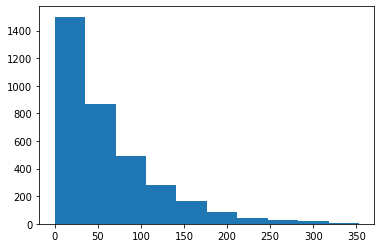

In [11]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(df2['customer_id'].unique())
tx_user.columns = ['CustomerID']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = df2.groupby('customer_id').transaction_date.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

plt.hist(tx_user['Recency'])
plt.show()

K-Means clustering for assign recency a score

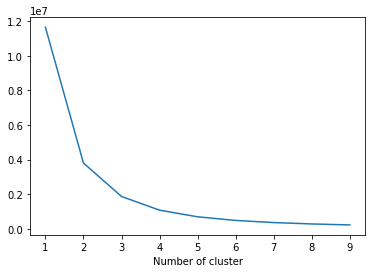

In [12]:
#For finding out number of cluster
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
#plt.show()

#Plot shows number of cluster should be 3

#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [14]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])
tx_user


,CustomerID,Recency,RecencyCluster
0,1,7,1
1,5,16,1
2,8,22,1
3,13,27,1
4,15,35,1
...,...,...,...
3484,3484,79,3
3485,3492,80,3
3486,3493,93,3
3487,3497,52,3


The results are as follows:<br>
(3,1773),    (2,1062),     (1,497),     (0,157)<br>
3 covers us a most recent customer while 0 has the most inactive ones<br>
Let's calculate frequency now

In [ ]:
#get order counts for each user and create a dataframe with it
tx_frequency = df2.groupby('customer_id').transaction_date.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.describe()

,CustomerID,Recency,RecencyCluster,Frequency
count,3489.000000,3489.000000,3489.000000,3489.000000
mean,1751.905704,60.807395,2.275724,5.723130
std,1009.388703,57.811419,0.868794,2.326339
min,1.000000,0.000000,0.000000,1.000000
25%,879.000000,17.000000,2.000000,4.000000
50%,1752.000000,44.000000,3.000000,6.000000
75%,2625.000000,85.000000,3.000000,7.000000
max,3500.000000,353.000000,3.000000,14.000000


In [ ]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1110.0,3.179279,0.881287,1.0,3.0,3.0,4.00,4.0
1,1169.0,5.485885,0.500015,5.0,5.0,5.0,6.00,6.0
2,784.0,7.394133,0.488976,7.0,7.0,7.0,8.00,8.0
3,426.0,9.927230,1.156815,9.0,9.0,10.0,10.75,14.0


Here 3 indicates better customers and 0 the worst customers w.r.t frequency.<br>
(0,1110),     (1,1169),      (2,991),      (3,219)    <br>
Hence, let's move to calculating moentary value of each customers


In [ ]:
#calculate revenue for each customer
tx_revenue = df2.groupby('customer_id').list_price.sum().reset_index()
tx_user.head()
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, right_on='customer_id', left_on = 'CustomerID')
tx_user.head()


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,customer_id,list_price
0,1,7,3,11,3,1,9084.45
1,8,22,3,10,3,8,12024.76
2,25,5,3,12,3,25,9996.33
3,29,22,3,9,3,29,10855.57
4,37,7,3,9,3,37,11291.71


In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['list_price']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['list_price']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'list_price',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['list_price'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,930.0,2951.642000,1019.765089,60.34,2285.2625,3157.495,3811.8225,4327.44
1,1313.0,5707.486253,792.882009,4335.00,5025.9500,5698.140,6354.3000,7139.17
2,910.0,8555.258736,902.634946,7143.39,7775.7000,8454.320,9253.8750,10378.00
3,336.0,12190.205833,1579.734607,10388.83,10950.1275,11818.950,12925.4650,19071.32


In [ ]:
tx_user.columns
tx_user.columns = ['CustomerID', 'Recency', 'RecencyCluster', 'Frequency','FrequencyCluster', 'customer_id', 'Revenue', 'RevenueCluster']

In [ ]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Recency,Frequency,Revenue
OverallScore,,,
0,241.592233,2.271845,2230.762913
1,151.645933,2.861244,2943.079665
2,95.047198,3.451327,3598.537729
3,62.684512,3.965583,4183.382371
4,55.844860,5.100935,5525.945832
5,39.595070,5.838028,6331.751972
6,40.426573,6.911422,7778.144103
7,29.758904,7.764384,8785.955315
8,28.463203,9.173160,10467.215411


In [ ]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [ ]:
tx_user.to_csv('RFM_final')

In [ ]:
df4 = tx_user.merge(df2, left_on = 'CustomerID', right_on = 'customer_id', how = 'inner')
df4.shape

(19968, 25)

In [ ]:
df4.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,customer_id_x,Revenue,RevenueCluster,OverallScore,Segment,customer_id_y,transaction_date,gender,list_price,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,owns_car,address,postcode,state,country,property_valuation
0,1,7,3,11,3,1,9084.45,2,8,High-Value,1,2017-12-09,F,742.54,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
1,1,7,3,11,3,1,9084.45,2,8,High-Value,1,2017-03-29,F,1274.93,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
2,1,7,3,11,3,1,9084.45,2,8,High-Value,1,2017-12-23,F,235.63,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
3,1,7,3,11,3,1,9084.45,2,8,High-Value,1,2017-04-06,F,1577.53,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,060 Morning Avenue,2016,New South Wales,Australia,10
4,1,7,3,11,3,1,9084.45,2,8,High-Value,1,2017-05-11,F,1720.70,93,1953-10-12,Executive Secretary,Health,Mass Customer,Yes,060 Morning Avenue,2016,New South Wales,Australia,10


In [ ]:
df4.to_csv('demoRFM.csv')

In [ ]:
df5 = df[['customer_id','transaction_date','gender','list_price','standard_cost']]

In [ ]:
df5['profit'] = df5['list_price'] - df5['standard_cost']
#calculate revenue for each customer
tx_profit = df5.groupby('customer_id').profit.sum().reset_index()
#merge it with our main dataframe
tx_user1 = pd.merge(tx_user, tx_profit, right_on='customer_id', left_on = 'CustomerID')
tx_user1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,customer_id_x,Revenue,RevenueCluster,OverallScore,Segment,customer_id_y,profit
0,1,7,3,11,3,1,9084.45,2,8,High-Value,1,3018.09
1,25,5,3,12,3,25,9996.33,2,8,High-Value,25,5333.66
2,41,29,3,9,3,41,9114.15,2,8,High-Value,41,4698.89
3,86,0,3,9,3,86,7319.35,2,8,High-Value,86,2360.09
4,87,18,3,9,3,87,7994.73,2,8,High-Value,87,3740.76


In [ ]:
tx_user1.to_csv('profit.csv')

In [ ]:
df.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'first_name', 'last_name', 'gender',
       'past_3_years_bike_related_purchases', 'DOB', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'default', 'owns_car', 'tenure'],
      dtype='object')

In [ ]:
df7 = df[['customer_id','transaction_date','online_order', 'order_status','gender','list_price','standard_cost','past_3_years_bike_related_purchases','DOB','job_industry_category','wealth_segment','owns_car','tenure','brand','product_line','product_class', 'product_size']]
df7['yob'] = pd.DatetimeIndex(df7['DOB']).year
df7['age'] = 2019 - df7['yob']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df8 = df7.merge(old_add, on = 'customer_id')

In [ ]:
df9 = df8.merge(tx_user, left_on = 'customer_id', right_on = 'CustomerID')
df9['profit'] = df9['list_price'] - df9['standard_cost']
df9.columns

Index(['customer_id_x', 'transaction_date', 'online_order', 'order_status',
       'gender', 'list_price', 'standard_cost',
       'past_3_years_bike_related_purchases', 'DOB', 'job_industry_category',
       'wealth_segment', 'owns_car', 'tenure', 'brand', 'product_line',
       'product_class', 'product_size', 'yob', 'age', 'address', 'postcode',
       'state', 'country', 'property_valuation', 'CustomerID', 'Recency',
       'RecencyCluster', 'Frequency', 'FrequencyCluster', 'customer_id_y',
       'Revenue', 'RevenueCluster', 'OverallScore', 'Segment', 'profit'],
      dtype='object')

In [ ]:
df10 = df9.drop(['list_price', 'standard_cost','DOB','yob','address', 'postcode','country','CustomerID','Recency', 'Frequency','Revenue'], axis = 1)

In [ ]:
df10['transmonth'] = pd.DatetimeIndex(df10['transaction_date']).month

In [ ]:
#calculate revenue for each customer
tx_revenue = df10.groupby('customer_id').list_price.sum().reset_index()
tx_user.head()
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, right_on='customer_id', left_on = 'CustomerID')
tx_user.head()


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,customer_id_x,Revenue,RevenueCluster,OverallScore,Segment,customer_id_y,list_price
0,1,7,3,11,3,1,9084.45,2,8,High-Value,1,9084.45
1,25,5,3,12,3,25,9996.33,2,8,High-Value,25,9996.33
2,41,29,3,9,3,41,9114.15,2,8,High-Value,41,9114.15
3,86,0,3,9,3,86,7319.35,2,8,High-Value,86,7319.35
4,87,18,3,9,3,87,7994.73,2,8,High-Value,87,7994.73
